# Curse of dimensionality

## Dimensionality reduction with Principal Component Analysis (PCA)

- PCA is an algorithm is commonly used techniques for data compression and data visualization. 
- PCA is also used for the identification of simple patterns, latent factors, and structures of high-dimensional data.
- In PCA, we want to find projection $\hat{x}_n$ of data point $x_n$ that are as similar to the original data points as possible, but which have a significantly lower instrinsic dimensionality. 
- Consider an i.i.d dataset $\chi =\{x_1, \dots, x_N\}, x_i \in R^d, i =1, \dots ,N$ with mean = 0 and the data covariance matrix
$$S = \frac{1}{N} \sum_{n=1}^N x_nx_n^T.$$
- Assume that there exists a low-dimensional compressed representation
$$ z_n =B^T x_n \in R^m
$$
of $x_n$, where $B$ is the projection matrix:
$$ B:= [b_1, \dots, b_M] \in R^{d\times m}
$$
This projection matrix is orthonomal so thate $b_i^Tb_j = 1$ if $i = j$  and $b_i^Tb_j = 0$ otherwise. 
- The problem is to seek an $m$-dimensional subspace $U\subset R^d$, where $dim(U) = m <d$ onto which we project the data. 

In [1]:
import numpy as np
import pandas as pd
import sklearn
import tensorflow as tf
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
np.random.seed(42)
Colors = ['#004165','#dc4200',  '#69be28', '#f0be00', '#0cc6de', '#bed600', '#006983', '2b580c', '639a67']

Project_Root_Directory = "."
Section_Id             = "Dimensionality Reduction"
Images_Path            = os.path.join(Project_Root_Directory, "images", Section_Id)
os.makedirs(Images_Path, exist_ok =True)

def plot_image(data):
    image = data.reshape(28, 28) # each image is 28 × 28 pixels
    plt.imshow(image, cmap = mpl.cm.binary, interpolation="nearest")
    plt.axis("off")
    
def plot_images(data, images_per_row =10, **options):
    size = 28
    images_per_row = min(len(data), images_per_row)
    images = [row.reshape(size, size) for row in data]
    n_rows = (len(data) -1 )// images_per_row + 1
    row_images = []
    n_empty = n_rows*images_per_row - len(data)
    images.append(np.zeros((size, size *n_empty)))
    for row in range(n_rows):
        rimages = images[row* images_per_row : (row+1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis =1))
    image = np.concatenate(row_images, axis =0)
    plt.imshow(image, cmap = "binary", **options)
    plt.axis("off")

##  Implement PCA
Suppose we perform PCA on some dataset $\chi$ of m principal components. There are two main parts
- Data normalization 
- Find eigenvalues and corresponding eigenvectors for the covariance matrix $S$. Sort by the largest eighenvalues and the corresponding eigenvectors.

In [2]:
def normalize(X):
    mu = np.mean(X, axis =0) # compute the mean of X
    std = np.std(X, axis =0)
    std_filled = std.copy()
    std_filled[std==0]= 1.  # replace 0 valued std by 1
    Xbar = ((X-mu)/std_filled) # normalized data with mean = 0 and standard deviation = 1. 
    return Xbar, mu, std

def eig(S):
    eigvalues, eigenvectors = np.linalg.eig(S)
    idx = np.argsort(eigvalues)[::-1]
    return eigvalues[idx], eigenvectors[:,idx]

def projection_matrix(B):
    return (B @ np.linalg.inv(B.T @ B) @ B.T)

def myPCA(X, n_components):
    S = 1.0/len(X) * np.dot(X.T, X)
    eigvals, eigvecs = eig(S)
    eigvals, eigvecs =  eigvals[:n_components], eigvecs[:,:n_components]
    B = np.real(eigvecs)    # dimensionality recduction of the original data
    reconstruction = (projection_matrix(B) @ X.T)
    return reconstruction.T

def mse(predict, actual):
    return np.square(predict - actual).sum(axis =1).mean()


## Comparing results with Sklearn PCA

In [3]:
# fetching data
from sklearn.datasets import fetch_openml
mnist, labels = fetch_openml('mnist_784', version=1, return_X_y=True)

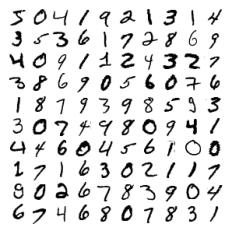

In [4]:
plot_images(mnist[:100])

# PCA using Scikit-Learn

In [5]:
n_datapoints = 1000
X = (mnist.reshape(-1, 28 * 28)[:n_datapoints]) 
Xbar, mu, std = normalize(X)

In [6]:
for num_component in range(1, 20):
    from sklearn.decomposition import PCA 
    pca = PCA(n_components=num_component, svd_solver='full')
    sklearn_reconst = pca.inverse_transform(pca.fit_transform(Xbar))
    reconst = myPCA(Xbar, num_component)
    np.testing.assert_almost_equal(reconst, sklearn_reconst)
    print(mse(reconst, sklearn_reconst))

2.3552251502687105e-28
6.226357195636889e-28
4.496474450997606e-28
4.108794782131743e-27
1.946797935188873e-27
3.654206531978132e-27
1.8679853296325347e-27
1.372015107816229e-27
5.252696247605688e-27
1.2422771990456606e-26
6.967647806347437e-25
2.991207597080415e-26
3.189989357355835e-26
1.5800238830018557e-26
8.279738217318249e-27
4.544761262795773e-26
7.155756788832706e-27
4.627855174919642e-27
1.1719499176639297e-26


In [7]:
loss = []
reconstructions = []

for n_component in range(1,10):
    reconst = myPCA(Xbar, n_component)
    error  = mse(reconst, Xbar)
    reconstructions.append(reconst)
    print('n = {:d}, reconstruction_error = {:f}'.format(n_component, error))
    loss.append((n_component, error))

reconstructions = np.asarray(reconstructions)
reconstructions = reconstructions * std + mu # "unnormalize" the reconstructed image
loss = np.asarray(loss)

n = 1, reconstruction_error = 569.447737
n = 2, reconstruction_error = 536.059608
n = 3, reconstruction_error = 508.250286
n = 4, reconstruction_error = 487.018907
n = 5, reconstruction_error = 467.571610
n = 6, reconstruction_error = 451.178087
n = 7, reconstruction_error = 436.538484
n = 8, reconstruction_error = 422.992021
n = 9, reconstruction_error = 411.014047


In [8]:
pd.DataFrame(loss, columns = ["n_components","loss"]).head()

,n_components,loss
0,1.0,569.447737
1,2.0,536.059608
2,3.0,508.250286
3,4.0,487.018907
4,5.0,467.571610


Text(0.5, 1.0, 'MSE vs number of principal components')

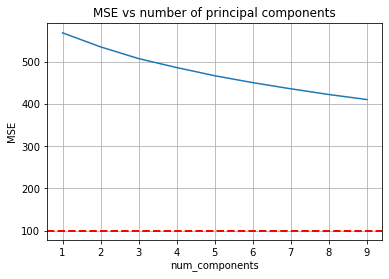

In [9]:
plt.plot(loss[:, 0], loss[:,1])
plt.axhline(100, linestyle ="--", color ="r", linewidth =2)
#plt.xticks(np.arange(1, 100, 5))
plt.xlabel('num_components')
plt.ylabel('MSE')
plt.grid()
plt.title('MSE vs number of principal components')

In [10]:
from sklearn.decomposition import PCA

pca = PCA(n_components =2)
X2D = pca.fit_transform(X)

In [11]:
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d

In [12]:
class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwarfs)
        self._verts3d = xs,ys,zs
    
    def draw(self, renderer):
        xs3d, ys3d, zs3d =self._verts3d
        xs,ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_position((xs[0], ys[0]), (xs[1], ys[1]))
        FancyArrowPatch.draw(self, renderer)

In [13]:
axes = [-1.8, 1.8, -1.3, 1.3, -1.0, 1.0]

x1s = np.linspace(axes[0], axes[1], 10)
x2s = np.linspace(axes[2], axes[3], 10)
x1, x2 = np.meshgrid(x1s, x2s)

C = pca.components_
R = C.T.dot(C)
z = (R[0, 2] * x1 + R[1, 2] * x2) / (1 - R[2, 2])

In [14]:
C

array([[-2.48543964e-18,  1.06573014e-18,  2.04650969e-19, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-3.70321644e-18,  1.09892713e-17,  9.91842799e-19, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

NameError: name 'X3D_inv' is not defined

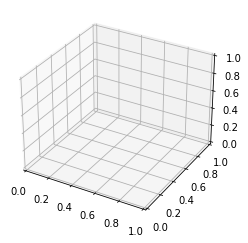

In [15]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

X3D_above = X[X[:, 2] > X3D_inv[:, 2]]
X3D_below = X[X[:, 2] <= X3D_inv[:, 2]]

ax.plot(X3D_below[:, 0], X3D_below[:, 1], X3D_below[:, 2], "bo", alpha=0.5)

ax.plot_surface(x1, x2, z, alpha=0.2, color="k")
np.linalg.norm(C, axis=0)
ax.add_artist(Arrow3D([0, C[0, 0]],[0, C[0, 1]],[0, C[0, 2]], mutation_scale=15, lw=1, arrowstyle="-|>", color="k"))
ax.add_artist(Arrow3D([0, C[1, 0]],[0, C[1, 1]],[0, C[1, 2]], mutation_scale=15, lw=1, arrowstyle="-|>", color="k"))
ax.plot([0], [0], [0], "k.")

for i in range(m):
    if X[i, 2] > X3D_inv[i, 2]:
        ax.plot([X[i][0], X3D_inv[i][0]], [X[i][1], X3D_inv[i][1]], [X[i][2], X3D_inv[i][2]], "k-")
    else:
        ax.plot([X[i][0], X3D_inv[i][0]], [X[i][1], X3D_inv[i][1]], [X[i][2], X3D_inv[i][2]], "k-", color="#505050")
    
ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], "k+")
ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], "k.")
ax.plot(X3D_above[:, 0], X3D_above[:, 1], X3D_above[:, 2], "bo")
ax.set_xlabel("$x_1$", fontsize=18, labelpad=10)
ax.set_ylabel("$x_2$", fontsize=18, labelpad=10)
ax.set_zlabel("$x_3$", fontsize=18, labelpad=10)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, aspect='equal')

ax.plot(X2D[:, 0], X2D[:, 1], "k+")
ax.plot(X2D[:, 0], X2D[:, 1], "k.")
ax.plot([0], [0], "ko")
ax.arrow(0, 0, 0, 1, head_width=0.05, length_includes_head=True, head_length=0.1, fc='k', ec='k')
ax.arrow(0, 0, 1, 0, head_width=0.05, length_includes_head=True, head_length=0.1, fc='k', ec='k')
ax.set_xlabel("$z_1$", fontsize=18)
ax.set_ylabel("$z_2$", fontsize=18, rotation=0)
ax.axis([-1.5, 1.3, -1.2, 1.2])
ax.grid(True)

In [ ]:
from sklearn.datasets import make_swiss_roll
X,t = make_swiss_roll(n_samples =1000, noise =0.2, random_state = 42)
fig = plt.figure(figsize=(8, 7))
ax = fig.add_subplot(111, projection ="3d")
ax.scatter(X[:,0], X[:,1], X[:,2], c =t, cmap = plt.cm.plasma)
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)

In [ ]:
plt.figure(figsize =(11,4))
plt.subplot(121)
plt.scatter(X[:,0], X[:,1], c= t, cmap= plt.cm.plasma)
plt.xlabel("$X_1$")
plt.ylabel("$X_2$")
plt.subplot(122)
plt.scatter(t, X[:,1], c =t, cmap = plt.cm.plasma)
plt.xlabel("$Z_1$")
plt.grid()

In [ ]:
from matplotlib import gridspec

axes =[-11.5, 14, -2, 23, -12, 15]
x2s = np.linspace(axes[2], axes[3], 10)
x3s = np.linspace(axes[4], axes[5], 10)
x2, x3 = np.meshgrid(x2s, x3s)
fig = plt.figure(figsize=(8,7))
ax = plt.subplot(111, projection="3d")
k= 3
positive_index = X[:, 0]> k
X_pos = X[positive_index]
X_neg = X[~positive_index]

ax.plot(X_neg[:, 0], X_neg[:,1], X_neg[:,2], "y^")
ax.plot_wireframe(k, x2, x3, alpha =.5)
ax.plot(X_pos[:, 0], X_pos[:,1], X_pos[:,2], "gd")
ax.set_xlabel("$x_1$")
ax.set_ylabel("$y_1$")
ax.set_zlabel("$z_1$")

In [ ]:
# PCA

angle = np.pi/5
stretch  = 5
m =200

np.random.seed(3)
X = np.random.randn(m,2)/10
X = X.dot(np.array([[stretch, 0], [0,1]]))
X = X.dot([[np.cos(angle), np.sin(angle)], [-np.sin(angle), np.cos(angle)]]) # rotate

u1 = np.array([np.cos(angle), np.sin(angle)])

In [ ]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

mnist = fetch_openml("mnist_784", version =1, as_frame = False)
mnist.target = mnist.target.astype(np.uint8)
X = mnist["data"]
y = mnist["target"]
X_train,X_test, y_train,y_test = train_test_split(X,y) 

pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) +1

In [ ]:
d

In [ ]:
plt.plot(cumsum,color ="darkred", linewidth = 3)
plt.axis([0,400, 0,1])
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
plt.plot([d,d], [0, .95], "k:")
plt.plot([0,d], [0.95, .95], "k:")
plt.plot(d, .95, "ko")
plt.annotate("Elbow", xy = (65, 0.85), xytext =(70, .7),
            arrowprops = dict(arrowstyle = "->"), fontsize =16)
plt.grid()
plt.show()

In [ ]:
pca = PCA(n_components =.95)
X_reduced = pca.fit_transform(X_train)
pca.n_components_